In [24]:
from __future__ import division
import os
from ipywidgets import interact
from ipywidgets import widgets
import nibabel as nb
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import blob_log
from sklearn.mixture import GaussianMixture
import scipy
import glob
%matplotlib inline

In [2]:
histogram = np.genfromtxt("../data/set_train_histogram.csv", skip_header=True, delimiter=",")
n = 1000000
histogram[:, 1] /= np.sum(histogram[:, 1])
sampling = np.random.choice(histogram[:, 0], size=(n, 1), p=histogram[:, 1])
weights = np.array([0.06, 0.72, 0.22])
means = np.array([268.8299584, 825.967384, 1339.920449]).reshape(-1, 1)
covariance = np.array([65.4319413**2, 261.051618**2, 93.081572**2]).reshape(-1, 1)

In [31]:
gm.get_params()
print(gm.means_)
print(np.sqrt(gm.covariances_))
print(gm.weights_)
print(gm.n_iter_)

[[  721.13707093]
 [  962.07575898]
 [ 1338.2421026 ]]
[[ 288.57625211]
 [ 181.09292551]
 [  95.33524694]]
[ 0.60521329  0.16867787  0.22610884]
843


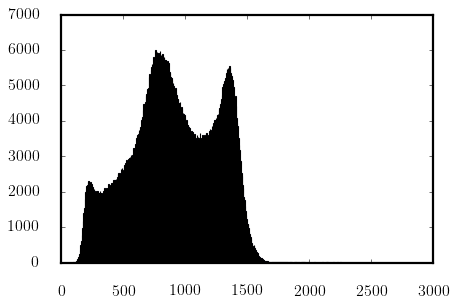

In [32]:
plt.figure()
plt.hist(sampling, bins=600);

In [ ]:
plt.figure()
plt.plot(histogram[:, 0], histogram[:, 1])
plt.vlines(gm.means_, ymin=0, ymax=np.max(histogram[:, 1]))

[   0    1    2 ..., 2997 2998 2999]


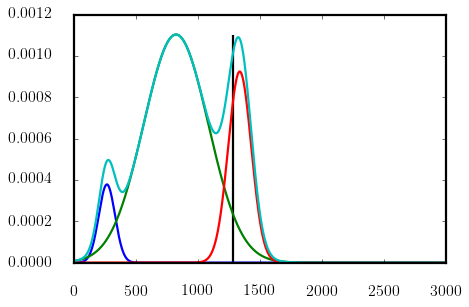

In [17]:
weights = np.array([0.0620489, 0.722237, 0.215714])
means = np.array([268.8299584, 825.967384, 1339.920449])
sds = np.array([65.4319413, 261.051618, 93.081572])

pdfs = [scipy.stats.norm(loc=mean, scale=sd) for mean, sd in zip(means, sds)]

plt.figure()
x = np.arange(0, 3000, 1)
print(x)
plt.plot(x, weights[0]*pdfs[0].pdf(x))
plt.plot(x, weights[1]*pdfs[1].pdf(x))
plt.plot(x, weights[2]*pdfs[2].pdf(x))
plt.plot(x, weights[0]*pdfs[0].pdf(x) + weights[1]*pdfs[1].pdf(x) + weights[2]*pdfs[2].pdf(x))
gm_wm_threshold = x[np.argmax(weights[2]*pdfs[2].pdf(x) / weights[1]*pdfs[1].pdf(x))]
plt.vlines(gm_wm_threshold, ymin=0, ymax=np.max(weights[1] * pdfs[1].pdf(x)))

1282


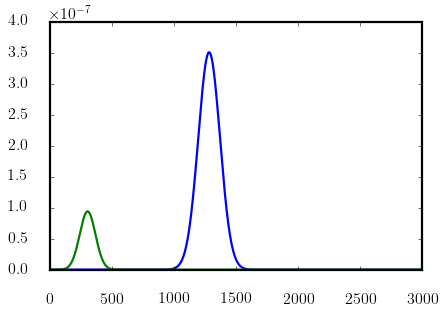

In [14]:
plt.figure()
plt.plot(x, weights[2]*pdfs[2].pdf(x) / weights[1]*pdfs[1].pdf(x))
plt.plot(x, weights[0]*pdfs[0].pdf(x) / weights[1]*pdfs[1].pdf(x))


In [36]:
def show_image(path, x, y, z):
    img = nb.load(path).get_data()[..., 0]
    limits = (0, 2000)
    fig = plt.figure(figsize=(20, 20)) 
    plt.subplot(1, 3, 1)
    plt.imshow(img[:, :, z],
                        cmap=plt.cm.gray,
                        interpolation='none'
                        )
    plt.clim(*limits)
    plt.subplot(1, 3, 2)
    plt.imshow(img[:, y, :],
                        cmap=plt.cm.gray,
                        interpolation='none'
                        )
    plt.clim(*limits)
    plt.subplot(1, 3, 3)
    plt.imshow(img[x, :, :],
                        cmap=plt.cm.gray,
                        interpolation='none'
              )
    plt.clim(*limits)
    segmentation_seed = np.zeros(img.shape, dtype=np.uint8)
    segmentation_seed[img == 0] = 1
    segmentation_seed[np.logical_and(img > 0, img < 300)] = 2
    segmentation_seed[np.logical_and(img > 650, img < 850)] = 3
    segmentation_seed[np.logical_and(img > 1050, img < 1450)] = 4     
    fig = plt.figure(figsize=(20, 20)) 
    plt.subplot(1, 3, 1)
    plt.imshow(np.rot90(segmentation_seed[:, :, z]),
                        cmap=plt.cm.gray,
                        interpolation='none'
                        )
    
    plt.subplot(1, 3, 2)
    plt.imshow(np.rot90(segmentation_seed[:, y, :]),
                        cmap=plt.cm.gray,
                        interpolation='none'
                        )
    plt.subplot(1, 3, 3)
    plt.imshow(np.rot90(segmentation_seed[x, :, :]),
                        cmap=plt.cm.gray,
                        interpolation='none'
              )
    plt.figure()
    plt.hist(img[img > 0].flatten(), bins=256)
    plt.yscale('log', nonposy='clip')

<function __main__.show_image>

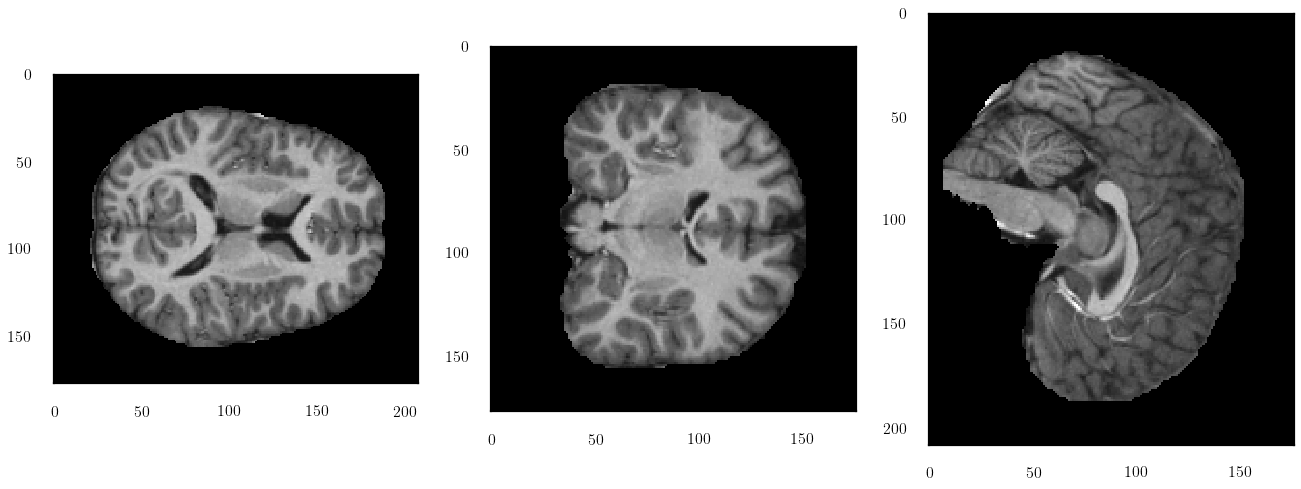

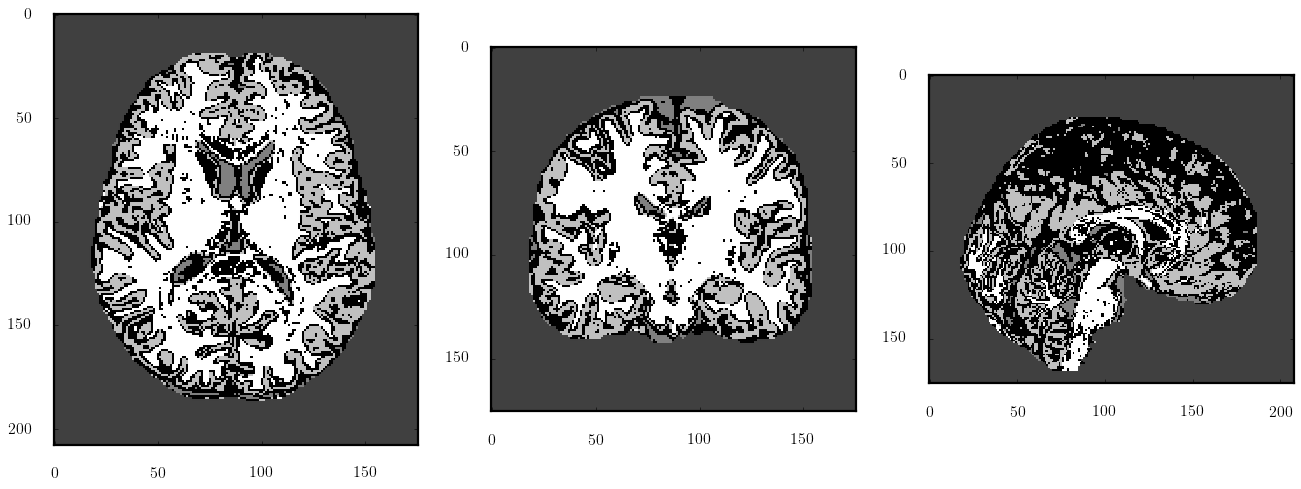

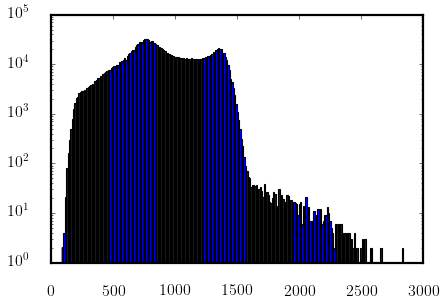

In [37]:
shape = (176, 208, 176)
path = widgets.Text("../data/set_train/train_1.nii")
interact(
    show_image,
    path=path,
    x=widgets.IntSlider(min=0, max=shape[0] - 1, step=1, value=shape[0] // 2),
    y=widgets.IntSlider(min=0, max=shape[1] - 1, step=1, value=shape[1] // 2),
    z=widgets.IntSlider(min=0, max=shape[2] - 1, step=1, value=shape[2] // 2),
)

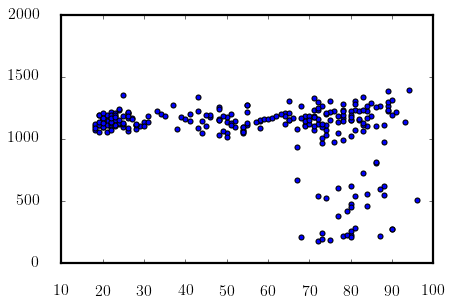

In [49]:
file_names = glob.glob("../data/set_train/train_*.nii")
def get_voxel(x, y, z):
    age_id = np.genfromtxt("../data/targets.csv")
    voxels = np.zeros(shape=len(file_names), dtype=np.int16)
    ages = np.zeros(shape=len(file_names), dtype=np.int16)
    for j, file_name in enumerate(file_names):
        index = int(os.path.splitext(os.path.basename(file_name))[0].split("_")[1]) - 1
        voxel = nb.load(file_name).dataobj[x, y, z]
        voxels[j] = voxel
        ages[j] = age_id[index]
    plt.figure()
    plt.scatter(ages, voxels)
    plt.ylim(0, 2000)
interact(
    get_voxel,
    x=widgets.IntSlider(min=0, max=shape[0] - 1, step=1, value=shape[0] // 2),
    y=widgets.IntSlider(min=0, max=shape[1] - 1, step=1, value=shape[1] // 2),
    z=widgets.IntSlider(min=0, max=shape[2] - 1, step=1, value=shape[2] // 2),
    )